In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

In [2]:
from nba_dfs_data_scraper import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
year = 2019
options = ['schedule', 'player_fd', 'team', 'dnp']
data_dict = {option: pd.read_csv(f'data/{option}_{year}.csv') 
             for option in options}

In [5]:
# Print the shapes of all datasets
for option in options:
    print(f'{option}: {data_dict[option].shape}')

schedule: (1230, 16)
player_fd: (26098, 44)
team: (2460, 38)
dnp: (14309, 5)


In [6]:
schedule_df = data_dict['schedule'].copy()
team_df = data_dict['team'].copy()
player_df = data_dict['player_fd'].copy()

## Get opponent's position Fanduel points data

In [7]:
matchup_df = team_df[['Game_No', 'Team', 'Opponent']]
# Build dictionary
matchup_dict = {f'{str(row[0])},{row[1]}': row[2]
                for row in matchup_df.values}

In [8]:
gb_order = ['Game_No', 'Team', 'Pos']
pts_by_pos_df = player_df.groupby(gb_order).FD_Pts.sum().reset_index()
pts_by_pos_df['Game_No_Team'] = pts_by_pos_df['Game_No'].apply(str) + \
                                ',' + pts_by_pos_df['Team']
pts_by_pos_df['Opponent'] = pts_by_pos_df['Game_No_Team'].apply(lambda x: matchup_dict[x])
pts_by_pos_df = pts_by_pos_df.drop('Game_No_Team', axis=1)
pts_by_pos_df.head(10)

,Game_No,Team,Pos,FD_Pts,Opponent
0,1,Boston Celtics,C,42.1,Philadelphia 76ers
1,1,Boston Celtics,PF,74.5,Philadelphia 76ers
2,1,Boston Celtics,PG,46.6,Philadelphia 76ers
3,1,Boston Celtics,SF,29.2,Philadelphia 76ers
4,1,Boston Celtics,SG,32.1,Philadelphia 76ers
5,1,Philadelphia 76ers,C,42.0,Boston Celtics
6,1,Philadelphia 76ers,PF,21.8,Boston Celtics
7,1,Philadelphia 76ers,PG,87.5,Boston Celtics
8,1,Philadelphia 76ers,SF,22.2,Boston Celtics
9,1,Philadelphia 76ers,SG,19.9,Boston Celtics


In [9]:
print(f'Assumed data shape: {team_df.shape[0] * 5}')
print(f'Real data shape: {pts_by_pos_df.shape[0]}')

Assumed data shape: 12300
Real data shape: 12072


In [10]:
pts_by_pos_df.Game_No.max()

1230

In [11]:
assumed_df = pts_by_pos_df[['Game_No', 'Team', 'Opponent']].drop_duplicates()
assumed_df = pd.concat([assumed_df for i in range(5)]).sort_index()
positions = ['C', 'PF', 'PG', 'SF', 'SG']
assumed_df['Pos'] = positions * len(matchup_df)

In [12]:
def minus_duplicates(l):
    result = []
    for i in range(1, len(l)):
        if l[i] != l[i-1]:
            result.append(l[i-1])
            if i == len(l) - 1:
                result.append(l[i])
        else:
            if i == len(l) - 1:
                result.append(l[i])
    return result

# Check
if minus_duplicates(list(assumed_df.Team.values)) == \
   minus_duplicates(list(pts_by_pos_df.Team.values)):
    print('Yes')

Yes


In [13]:
pts_by_pos_df = assumed_df.merge(pts_by_pos_df, how='left').fillna(0)
pts_by_pos_df.shape

(12300, 5)

In [14]:
pts_by_pos_df.head(10)

,Game_No,Team,Opponent,Pos,FD_Pts
0,1,Boston Celtics,Philadelphia 76ers,C,42.1
1,1,Boston Celtics,Philadelphia 76ers,PF,74.5
2,1,Boston Celtics,Philadelphia 76ers,PG,46.6
3,1,Boston Celtics,Philadelphia 76ers,SF,29.2
4,1,Boston Celtics,Philadelphia 76ers,SG,32.1
5,1,Philadelphia 76ers,Boston Celtics,C,42.0
6,1,Philadelphia 76ers,Boston Celtics,PF,21.8
7,1,Philadelphia 76ers,Boston Celtics,PG,87.5
8,1,Philadelphia 76ers,Boston Celtics,SF,22.2
9,1,Philadelphia 76ers,Boston Celtics,SG,19.9


In [15]:
pts_by_pos_df['Team+'] = pts_by_pos_df['Game_No'].apply(str) + \
                         ',' + pts_by_pos_df['Team'] + ',' + \
                         pts_by_pos_df['Pos']
pts_by_pos_df['Oppo+'] = pts_by_pos_df['Game_No'].apply(str) + \
                         ',' + pts_by_pos_df['Opponent'] + ',' + \
                         pts_by_pos_df['Pos']
fd_pts_df = pts_by_pos_df[['Team+', 'FD_Pts']]
fd_pts_dict = {row[0]: row[1] for row in fd_pts_df.values}
pts_by_pos_df['Opp_FD_Pts'] = pts_by_pos_df['Oppo+'].apply(lambda x: fd_pts_dict[x])
pts_by_pos_df = pts_by_pos_df.drop(['Team+', 'Oppo+'], axis=1)
pts_by_pos_df.head(10)

,Game_No,Team,Opponent,Pos,FD_Pts,Opp_FD_Pts
0,1,Boston Celtics,Philadelphia 76ers,C,42.1,42.0
1,1,Boston Celtics,Philadelphia 76ers,PF,74.5,21.8
2,1,Boston Celtics,Philadelphia 76ers,PG,46.6,87.5
3,1,Boston Celtics,Philadelphia 76ers,SF,29.2,22.2
4,1,Boston Celtics,Philadelphia 76ers,SG,32.1,19.9
5,1,Philadelphia 76ers,Boston Celtics,C,42.0,42.1
6,1,Philadelphia 76ers,Boston Celtics,PF,21.8,74.5
7,1,Philadelphia 76ers,Boston Celtics,PG,87.5,46.6
8,1,Philadelphia 76ers,Boston Celtics,SF,22.2,29.2
9,1,Philadelphia 76ers,Boston Celtics,SG,19.9,32.1


In [16]:
# Reshape
for pos in positions:
    fd_pts = list(pts_by_pos_df[pts_by_pos_df.Pos == pos].FD_Pts.values)
    opp_pts = list(pts_by_pos_df[pts_by_pos_df.Pos == pos].Opp_FD_Pts.values)   
    pts_by_pos_df[f'FD_Pts_{pos}'] = [n for n in fd_pts for i in range(5)]
    pts_by_pos_df[f'Opp_FD_Pts_{pos}'] = [n for n in opp_pts for i in range(5)]

pts_by_pos_df = pts_by_pos_df.drop(['FD_Pts', 'Opp_FD_Pts', 'Pos'], axis=1)\
                             .drop_duplicates()\
                             .reset_index()\
                             .drop('index', axis=1)
pts_by_pos_df.head()

,Game_No,Team,Opponent,FD_Pts_C,Opp_FD_Pts_C,FD_Pts_PF,Opp_FD_Pts_PF,FD_Pts_PG,Opp_FD_Pts_PG,FD_Pts_SF,Opp_FD_Pts_SF,FD_Pts_SG,Opp_FD_Pts_SG
0,1,Boston Celtics,Philadelphia 76ers,42.1,42.0,74.5,21.8,46.6,87.5,29.2,22.2,32.1,19.9
1,1,Philadelphia 76ers,Boston Celtics,42.0,42.1,21.8,74.5,87.5,46.6,22.2,29.2,19.9,32.1
2,2,Golden State Warriors,Oklahoma City Thunder,31.0,59.1,63.7,39.4,73.1,9.1,48.6,43.9,24.2,74.0
3,2,Oklahoma City Thunder,Golden State Warriors,59.1,31.0,39.4,63.7,9.1,73.1,43.9,48.6,74.0,24.2
4,3,Charlotte Hornets,Milwaukee Bucks,30.1,20.1,28.3,43.2,72.5,27.3,50.1,53.6,51.7,82.2


In [17]:
pts_by_pos_df.shape

(2460, 13)

In [18]:
# Merge
team_df = col_order_adjust(team_df, ['Date']).merge(pts_by_pos_df)
team_df.head()

,Date,Team,Game_No,is_Home,Opponent,MP,FG,FGA,FG%,3P,...,FD_Pts_C,Opp_FD_Pts_C,FD_Pts_PF,Opp_FD_Pts_PF,FD_Pts_PG,Opp_FD_Pts_PG,FD_Pts_SF,Opp_FD_Pts_SF,FD_Pts_SG,Opp_FD_Pts_SG
0,2018-10-16,Boston Celtics,1,1.0,Philadelphia 76ers,240,42,97,0.433,11,...,42.1,42.0,74.5,21.8,46.6,87.5,29.2,22.2,32.1,19.9
1,2018-10-16,Philadelphia 76ers,1,0.0,Boston Celtics,240,34,87,0.391,5,...,42.0,42.1,21.8,74.5,87.5,46.6,22.2,29.2,19.9,32.1
2,2018-10-16,Golden State Warriors,2,1.0,Oklahoma City Thunder,240,42,95,0.442,7,...,31.0,59.1,63.7,39.4,73.1,9.1,48.6,43.9,24.2,74.0
3,2018-10-16,Oklahoma City Thunder,2,0.0,Golden State Warriors,240,33,91,0.363,10,...,59.1,31.0,39.4,63.7,9.1,73.1,43.9,48.6,74.0,24.2
4,2018-10-17,Charlotte Hornets,3,1.0,Milwaukee Bucks,240,41,92,0.446,16,...,30.1,20.1,28.3,43.2,72.5,27.3,50.1,53.6,51.7,82.2


## EDA

### Distribution of Fanduel points

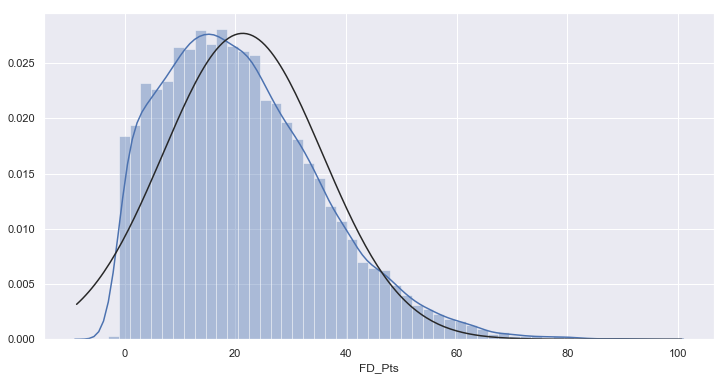

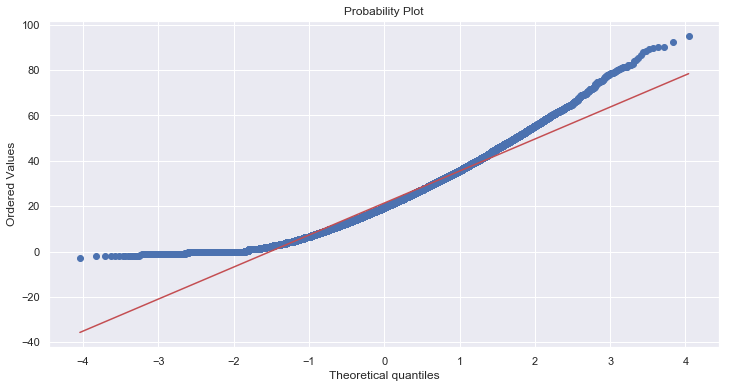

In [19]:
figsize(12, 6)
sns.set()
sns.distplot(player_df.FD_Pts, fit=norm)
fig = plt.figure()
res = stats.probplot(player_df.FD_Pts, plot=plt)

In [20]:
player_df.FD_Pts.min()

-3.0

Transform and see if the distribution is normal

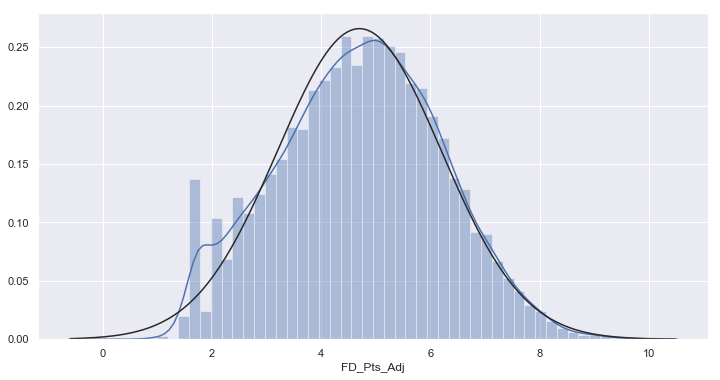

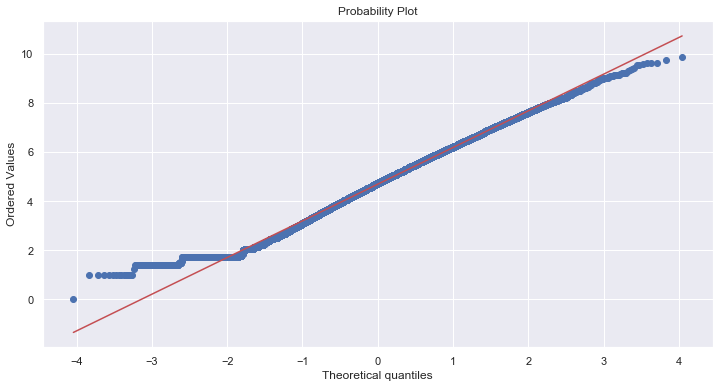

In [21]:
player_df['FD_Pts_Adj'] = (player_df['FD_Pts'] + 3) ** 0.5
figsize(12, 6)
sns.distplot(player_df.FD_Pts_Adj, fit=norm)
fig = plt.figure()
res = stats.probplot(player_df.FD_Pts_Adj, plot=plt)

### See correlation between salary and Fanduel points

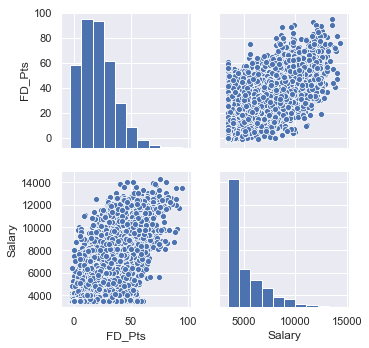

In [22]:
high_num_features = ['FD_Pts',
                     'Salary']
sns.set()
sns.pairplot(player_df[high_num_features])
plt.show()

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def naive_ln_model(X, y):
    reg_model = LinearRegression()
    reg_model.fit(X, y)
    pred = reg_model.predict(X)
    print(f"R_Squared: {r2_score(y, pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y, pred))}")
    return pred
    
X = player_df[['Salary']]
y = player_df.FD_Pts.values
pred = naive_ln_model(X, y)

R_Squared: 0.523984254484301
RMSE: 9.941149596289357


Transformed version

In [24]:
X = player_df[['Salary']]
y = player_df.FD_Pts_Adj.values
pred = naive_ln_model(X, y)
# transform back
pred = pred ** 2 - 3
print(f"RMSE (Transformed): {np.sqrt(mean_squared_error(player_df.FD_Pts, pred))}")

R_Squared: 0.4703768149670343
RMSE: 1.091880057181712
RMSE (Transformed): 10.256646876972304


## Feature Engineering

Get record over the last n games
- Game Start rate
- Average Minutes Played
- Average FD_Pts
- Average Usg%
- Median eFG%

### Get Rolling Averages

In [25]:
def str2datetime(x):
    # Handy function to convert str to datetime
    return datetime.strptime(x, '%Y-%m-%d')

In [26]:
# Convert Date from str to datetime
player_df['Date'] = player_df['Date'].apply(lambda x: str2datetime(x))
team_df['Date'] = team_df['Date'].apply(lambda x: str2datetime(x))

In [27]:
today = str2datetime('2019-3-26')

In [28]:
def get_rolling_records(today, player_df, n):
    # Delete all records after today
    player_df = player_df[player_df.Date <= today]
    print(f'Records til today: {player_df.shape[0]}')
    
    # Get base df
    base_cols = ['Player', 'Date', 'Pos', 'is_Home',
                 'Team', 'Opponent', 'Salary', 'FD_Pts']
    
    # Desired Stats
    mean_cols = ['GS', 'MP', 'USG%', 'FD_Pts']
    median_cols = ['eFG%', 'TS%']
    for col in mean_cols:
        base_cols.append(f'mean_{col}_last_{n}_gms')
    for col in median_cols:
        base_cols.append(f'median_{col}_last_{n}_gms')
    
    # Get other stats from the past n games
    players = list(set(player_df.Player.values))
    print(f'There are {len(players)} players.')
    p_dfs = []
    uq_sum = 0
    players_checked = 0
    for player in players:
        p_df = player_df[player_df.Player == player]
        if len(p_df) > n:
            for col in mean_cols:
                rolling_mean = [np.nan] + list(p_df[col].rolling(n).mean())[:-1]
                p_df[f'mean_{col}_last_{n}_gms'] = rolling_mean
            for col in median_cols:
                rolling_median = [np.nan] + list(p_df[col].rolling(n).median())[:-1]
                p_df[f'median_{col}_last_{n}_gms'] = rolling_median
            p_df = p_df[~p_df[f'median_{col}_last_{n}_gms'].isna()]
            p_dfs.append(p_df)
        else:
            uq_sum += 1
        players_checked += 1
        if players_checked % 100 == 0:
            print(f'{players_checked} players checked.')
    print(f'# of unqualified players: {uq_sum}')
    
    # Merge p_dfs
    new_player_df = pd.concat(p_dfs).sort_index()[base_cols]
    print(f'After processing, records til today: {new_player_df.shape[0]}')

    return new_player_df

In [29]:
new_player_df = get_rolling_records(today, player_df, 5)

Records til today: 23697
There are 519 players.
100 players checked.
200 players checked.
300 players checked.
400 players checked.
500 players checked.
# of unqualified players: 46
After processing, records til today: 21220


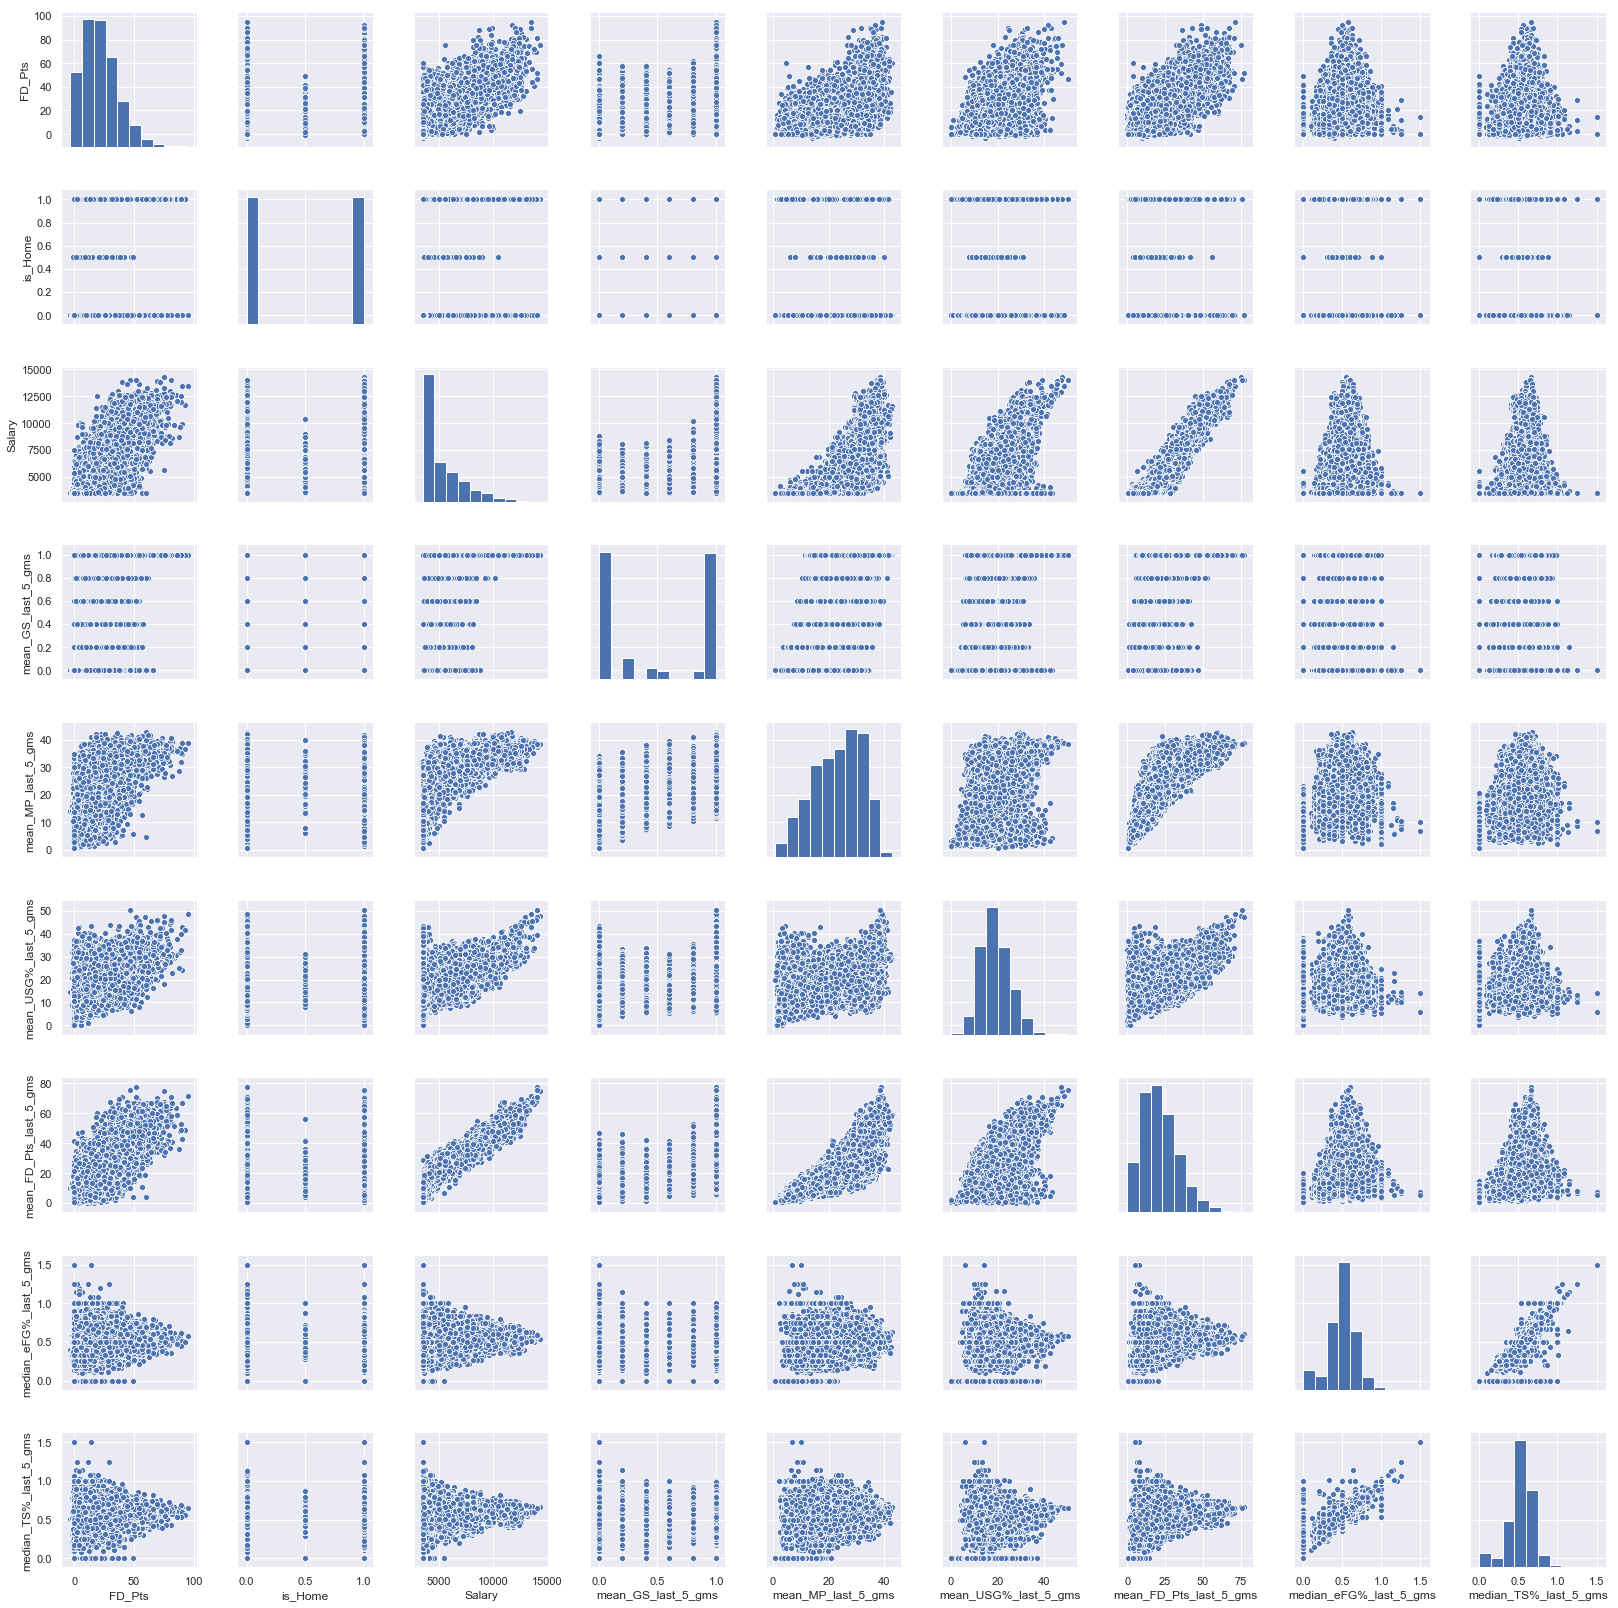

In [31]:
high_num_features = ['FD_Pts',
                     'is_Home', 'Salary',
                     'mean_GS_last_5_gms', 'mean_MP_last_5_gms',
                     'mean_USG%_last_5_gms', 'mean_FD_Pts_last_5_gms',
                     'median_eFG%_last_5_gms', 'median_TS%_last_5_gms']
sns.set()
sns.pairplot(new_player_df[high_num_features])
plt.show()

### Get Opponent FD Pts allowed

In [32]:
def get_opponent_history(new_player_df, team_df):
    keys = new_player_df[['Date', 'Opponent', 'Pos']].values
    oppo_fd_pts = []
    print(f'# of records: {len(new_player_df)}')
    keys_completed = 0
    for key in keys:
        temp = team_df[(team_df.Date < key[0]) &
                       (team_df.Team == key[1])]
        desired = temp[f'Opp_FD_Pts_{key[2]}'].mean()
        oppo_fd_pts.append(desired)
        keys_completed += 1
        if keys_completed % 2000 == 0:
            print(f'{keys_completed} records completed')
    
    return oppo_fd_pts

In [33]:
new_player_df['Opp_Pos_FD_Pts_Allowed'] = get_opponent_history(new_player_df, 
                                                               team_df)
new_player_df.head()

# of records: 21220
2000 records completed
4000 records completed
6000 records completed
8000 records completed
10000 records completed
12000 records completed
14000 records completed
16000 records completed
18000 records completed
20000 records completed


,Player,Date,Pos,is_Home,Team,Opponent,Salary,FD_Pts,mean_GS_last_5_gms,mean_MP_last_5_gms,mean_USG%_last_5_gms,mean_FD_Pts_last_5_gms,median_eFG%_last_5_gms,median_TS%_last_5_gms,Opp_Pos_FD_Pts_Allowed
1428,Nicolas Batum,2018-10-26,SF,1.0,Charlotte Hornets,Chicago Bulls,6400.0,35.1,1.0,35.416667,15.32,25.30,0.433,0.421,33.175
1429,Kemba Walker,2018-10-26,PG,1.0,Charlotte Hornets,Chicago Bulls,8500.0,45.7,1.0,34.913333,32.68,44.78,0.565,0.610,58.775
1430,Jeremy Lamb,2018-10-26,SG,1.0,Charlotte Hornets,Chicago Bulls,5600.0,19.8,1.0,25.083333,20.74,25.54,0.417,0.466,47.500
1431,Cody Zeller,2018-10-26,C,1.0,Charlotte Hornets,Chicago Bulls,4500.0,24.7,1.0,20.993333,13.10,20.00,0.625,0.717,46.500
1432,Marvin Williams,2018-10-26,PF,1.0,Charlotte Hornets,Chicago Bulls,4600.0,16.0,1.0,26.040000,15.46,22.36,0.375,0.427,46.725


### Box Cox Transformation

In [34]:
features = ['Salary',
            'mean_GS_last_5_gms', 'mean_MP_last_5_gms',
            'mean_USG%_last_5_gms', 'mean_FD_Pts_last_5_gms',
            'Opp_Pos_FD_Pts_Allowed']

In [35]:
skewness_df = new_player_df[features].skew()\
                                     .sort_values(ascending=False)\
                                     .reset_index()\
                                     .rename(columns={'index': 'features',
                                                      0: 'skewness'})
skewness_df
# Alternative function
# new_player_df[features].apply(lambda x: skew(x.dropna()))\
#                        .sort_values(ascending=False)

,features,skewness
0,Salary,1.349091
1,mean_FD_Pts_last_5_gms,0.739226
2,mean_USG%_last_5_gms,0.494800
3,Opp_Pos_FD_Pts_Allowed,0.264277
4,mean_GS_last_5_gms,0.086970
5,mean_MP_last_5_gms,-0.331780


In [36]:
skewness_df = skewness_df[abs(skewness_df.skewness) > 0.75]

from scipy.special import boxcox1p
transform_list = skewness_df.features.values
lambda_ = 0.15
for feature in transform_list:
    new_player_df[f'{feature}_adj'] = boxcox1p(new_player_df[feature], lambda_)
    features.remove(feature)
    features.append(f'{feature}_adj')

In [37]:
features

['mean_GS_last_5_gms',
 'mean_MP_last_5_gms',
 'mean_USG%_last_5_gms',
 'mean_FD_Pts_last_5_gms',
 'Opp_Pos_FD_Pts_Allowed',
 'Salary_adj']

## Modeling

In [39]:
new_player_df['FD_Pts_Adj'] = (new_player_df['FD_Pts'] + 3) ** 0.5

In [40]:
train_df = new_player_df[new_player_df.Date != today]
test_df = new_player_df[new_player_df.Date == today]
X_train = train_df[features]
y_train = train_df.FD_Pts_Adj.values
X_test = test_df[features]
y_test = test_df.FD_Pts_Adj.values

In [41]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.sort_values(by = 'VIF_Factor', ascending=False)

,VIF_Factor,features
5,80.512284,Salary_adj
4,58.441497,Opp_Pos_FD_Pts_Allowed
1,41.223945,mean_MP_last_5_gms
3,25.306459,mean_FD_Pts_last_5_gms
2,19.672064,mean_USG%_last_5_gms
0,4.835478,mean_GS_last_5_gms


In [42]:
def ln_model(X_train, y_train, X_test, y_test):
    print('Linear Regression:')
    reg_model = LinearRegression()
    reg_model.fit(X_train, y_train)
    pred_train = reg_model.predict(X_train)
    print(f"Train R_Squared: {r2_score(y_train, pred_train)}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, pred_train))}")
    pred_test = reg_model.predict(X_test)
    print(f"Test R_Squared: {r2_score(y_test, pred_test)}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, pred_test))}")
    return pred_test

pred_test = ln_model(X_train, y_train, X_test, y_test)
print(np.sqrt(mean_squared_error(y_test ** 2 - 3, pred_test ** 2 - 3)))

Linear Regression:
Train R_Squared: 0.5299735387619757
Train RMSE: 1.016395812763656
Test R_Squared: 0.5151972297418037
Test RMSE: 1.0514063689541437
9.887304515528966


In [43]:
from sklearn.ensemble import RandomForestRegressor

def rf_model(X_train, y_train, X_test, y_test):
    print('Random Forest')
    reg_model = RandomForestRegressor()
    reg_model.fit(X_train, y_train)
    pred_train = reg_model.predict(X_train)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_train, pred_train))}")
    pred_test = reg_model.predict(X_test)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_test))}")
    return pred_test

pred_test = rf_model(X_train, y_train, X_test, y_test)
print(np.sqrt(mean_squared_error(y_test ** 2 - 3, pred_test ** 2 - 3)))

Random Forest
RMSE: 0.45723324839278096
RMSE: 1.1267750364899325
10.625078637271649


In [47]:
from sklearn.ensemble import GradientBoostingRegressor

def gb_model(X_train, y_train, X_test, y_test):
    print('Gradient Boosting Regressor')
    reg_model = GradientBoostingRegressor()
    reg_model.fit(X_train, y_train)
    pred_train = reg_model.predict(X_train)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_train, pred_train))}")
    pred_test = reg_model.predict(X_test)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_test))}")
    return pred_test

pred_test = gb_model(X_train, y_train, X_test, y_test)
print(np.sqrt(mean_squared_error(y_test ** 2 - 3, pred_test ** 2 - 3)))

Gradient Boosting Regressor
RMSE: 0.9913559768153959
RMSE: 1.052983503925274
9.93814132439637


### Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

models_score = []

# Linear Regression
lr = LinearRegression()
lr_param_grid = {'n_jobs': [None, -1],
                 'fit_intercept': [True, False],
                 'normalize': [True, False],
                 'copy_X': [True, False]}
lr_gs = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=5)
lr_gs.fit(X_train, y_train)
lr_gs_score = lr_gs.score(X_test, y_test)
models_score.append((lr_gs_score, lr))

# Lasso
lasso = Lasso(random_state = 42)
lasso_param_grid = {'alpha': np.arange(start=0.01, stop=0.06, step=0.01),
                    'fit_intercept': [True, False]}
lasso_gs = GridSearchCV(estimator=lasso, 
                        param_grid=lasso_param_grid,
                        cv=5)
lasso_gs.fit(X_train, y_train)
lasso_gs_score = lasso_gs.score(X_test, y_test)
models_score.append((lasso_gs_score, lasso))

# Ridge
ridge = Ridge(solver = 'sparse_cg', random_state = 42)
ridge_param_grid = {'alpha': np.arange(start=0.01, stop=0.06, step=0.01),
                    'fit_intercept': [True, False]}
ridge_gs = GridSearchCV(estimator=ridge, 
                        param_grid=ridge_param_grid,
                        cv=5)
ridge_gs.fit(X_train, y_train)
ridge_gs_score = ridge_gs.score(X_test, y_test)
models_score.append((ridge_gs_score, ridge))

# ElasticNet
en = ElasticNet(random_state = 42)
en_param_grid = {'alpha': np.arange(start=0.01, stop=0.06, step=0.01),
                 'fit_intercept': [True, False]}
en_gs = GridSearchCV(estimator=en, 
                     param_grid=en_param_grid,
                     cv=5)
en_gs.fit(X_train, y_train)
en_gs_score = en_gs.score(X_test, y_test)
models_score.append((en_gs_score, en))

# RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
models_score.append((rf_score, rf))

# GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
models_score.append((gb_score, gb))

# Select best model
best_model = sorted(models_score, reverse = True)[0][1]
best_model

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)